The computation and exploration of Bayesian posterior distributions are aimed at calibrating parameters within the structure of a given model. It can also happen that our ignorance goes beyond the model parameters and can affect the model structure itself. A common problem in this scenario is how to quantify which model is the most suitable for explaining the experimental data or which hypotheses are not supported anymore.

Performing a hypothesis testing study entails the evaluation of the posterior probabilities of each competing model (or hypothesis in our context). This comparison allows us to weigh the relative merit of each model. At first thought, we might consider the most suitable model to be the one that best fits the data. Difficulties quickly arise as we aim at comparing models of different complexity. More complex models involving the definition of more parameters can generally be more expressive and fit very well the data. In this case, the results of hypothesis testing studies have the philosophical principle of Ockham's razor built in them. This principle embodies the fact that the simplest models that can explain comparatively well the data are the preferred ones. 

We'll continue using the same Python libraries than for the previous exercises.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from numpy import random
import scipy
from scipy.optimize import minimize
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
from sklearn.neighbors import KernelDensity

We again define a polynomial model that can take different forms depending on the number of coefficients taken into account.

In [2]:
def polynomial(a,x): # a is a vector with the polynomial coefficients in increasing order of polynomial degree
    a_tot = 0.
    for i in range(len(a)):
      a_tot += a[i]*np.power(x,i)
    return a_tot

Generate the noisy observations with a "true polynomial".

In [3]:
# Random seed for the observations
# np.random.seed(2) # Uncomment if you want to compare different fittings when choosing different noise levels, observations or priors.
number_obs = 30 # Number of noisy observations generated
number_xs = 1000 # Number of x coordinate points to plot solutions once the fitting is done

# Mesh on x
x = np.linspace(0,1,number_xs)
spacing = int(number_xs/number_obs) # Spacing used to generate the observations at those x locations

# Generating the observations
x_obs = [x[spacing*i] for i in range(number_obs)] # spacing points on x
a_true = [10., -2., 7.5, -3.3, -3.2] # The true polynomial coefficients
sigma_obs = 0.1
observations = [polynomial(a_true,x[spacing*i])+np.random.normal(0,sigma_obs) for i in range(number_obs)] # The noisy observations

We now perform the inference of the coefficients defined under each model considered. In this case, we prescribe 3 models with 2, 3 and 7 coefficients, respectively. It is recalled that we want to  find the model that best explains the observations. We then plot the marginal posteriors of a common coefficient "a_1" which refers to the linear part of the models.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (1 chains in 1 job)
NUTS: [a_1, a_0]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (1 chains in 1 job)
NUTS: [a_2, a_1, a_0]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 56 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (1 chains in 1 job)
NUTS: [a_6, a_5, a_4, a_3, a_2, a_1, a_0]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 211 seconds.
There were 2439 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.685641425271613, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


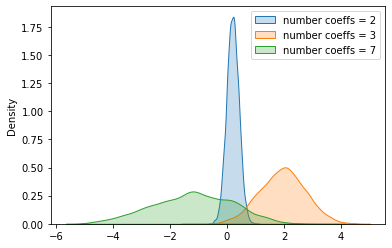

In [4]:
n_models = 3
# number_coeffs = [2,3,5]
number_coeffs = [2,3,7]
dict1 = dict.fromkeys(['model_'+str(i) for i in range(len(number_coeffs))], 0)

for i in range(n_models):

  # number_coeffs = 5
  names_coeffs = ['a_'+str(j) for j in range(number_coeffs[i])]

  with pm.Model():

          vect_var = [] # Vector of parameters for which we specify priors
          for j in range(len(names_coeffs)):
            var_coeffs = pm.Uniform(names_coeffs[j], lower=-5., upper=20.) # Uniform priors with prescribed bounds. Look in the documentation of pyMC3 to find other prior models
            vect_var.append(var_coeffs)

          # convert coefficients to a tensor vector with theano (required by pyMC3 to work)
          theta = tt.as_tensor_variable(vect_var)

          # use a normal multivariate distribution as likelihood (noise taken as independet Gausssian distributions)
          mu = [polynomial(vect_var,x_obs[k]) for k in range(number_obs-1)] # Vector of mean values which are composed of the evaluations of the proposed model
          cov = sigma_obs*np.identity(number_obs-1) # Covariance (noise of the observations)
          pm.MvNormal('likelihood', mu=mu, cov=cov, observed=observations[0:number_obs-1])

          step = pm.NUTS() # NUTS MCMC sampler. You can also try Metropolis or any other in the pyMC3 library!
          trace = pm.sample(10000, tune=1000, discard_tuned_samples=True, step=step, chains=1) # We get 10000 chain samples and discard the first 1000 that serve to tune the chain parameters
          dict1['model_'+str(i)] = trace['a_1']
          sns.kdeplot(trace['a_1'],shade=True,label="number coeffs = "+str(number_coeffs[i]))
plt.legend()
        # pm.plot_posterior(trace)
      

We define the Gaussian kernel from which to compute the likelihood of the observations under each considered model.

In [5]:
def gaussian_kernel(h,x):
    mean = h[0]
    std = h[1]
    return np.divide(1,std*np.sqrt(2.*np.pi))*np.exp(-0.5*np.divide(x - mean, std)**2)

In [6]:
def likelihood(a):
  lik_value = 1.
  for i in range(number_obs):
    h = [observations[i],sigma_obs]
    lik_value *= gaussian_kernel(h,polynomial(a,x_obs[i]))
  return lik_value

To perform the model assessment we need to compare the posterior distributions for the different models. The comparison is driven through the posterior ratio 

$\dfrac{\mathcal{P}(\mathcal{M}_{1} \vert \boldsymbol y_{\mathrm{obs}})}{\mathcal{P}(\mathcal{M}_{0} \vert \boldsymbol y_{\mathrm{obs}})}$,

where $\mathcal{M}_{0}$ and $\mathcal{M}_{1}$ are the two competing models we are considering. If the posterior ratio is very much less than one, we would prefer model $\mathcal{M}_{0}$ and viceversa. If the ratio is of order unity then the data do not provide enough evidence to preferentially support either model. To analyse the effects of the different components on the model posteriors and the ratio, we can decompose it according to the Bayes' rule

$\dfrac{\mathcal{P}(\mathcal{M}_{1} \vert \boldsymbol y_{\mathrm{obs}})}{\mathcal{P}(\mathcal{M}_{0} \vert \boldsymbol y_{\mathrm{obs}})} = \dfrac{\mathcal{P}(\boldsymbol y_{\mathrm{obs}} \vert \mathcal{M}_{1})}{\mathcal{P}(\boldsymbol y_{\mathrm{obs}} \vert \mathcal{M}_{0})} \times \dfrac{\mathcal{P}(\mathcal{M}_{1})}{\mathcal{P}(\mathcal{M}_{0})}$,

where the posterior ratio is expressed as the product of the ratio of the marginalized likelihoods and priors of the different models. The marginalized likelihoods of the different models can also be expressed as the marginalization over each model's parameters prior as

$\mathcal{P}(\boldsymbol y_{\mathrm{obs}} \vert \mathcal{M}_{i}) = \int_{\mathcal{X}} \mathcal{P}(\boldsymbol y_{\mathrm{obs}} \vert \boldsymbol x_{i}, \mathcal{M}_{i})\mathcal{P}(\boldsymbol x_{i} \vert \mathcal{M}_{i})\mathrm{d}\boldsymbol x_{i}, \ \ \forall i \in \{0, 1\}$,

where $\boldsymbol x_{i}$ is the vector of model parameters of each model and $\mathcal{P}(\boldsymbol x_{i} \vert \mathcal{M}_{i})$ is the prior for $\boldsymbol x_{i}$ under model $\mathcal{M}_{i}$. $\mathcal{P}(\boldsymbol y_{\mathrm{obs}} \vert \mathcal{M}_{i})$ is also known as the evidence of the data under model $\mathcal{M}_{i}$ and it is the factor in the Bayes' rule denominator which is often disregarded as a proportionality constant in parameter inference. The evidence ratio expresses the merit of each model based on two distinct aspects: how well the data is fitted, through the presence of the likelihood $\mathcal{P}(\boldsymbol y_{\mathrm{obs}} \vert \boldsymbol x_{i}, \mathcal{M}_{i})$, and how much prior space is given to each model $\mathcal{P}(\boldsymbol x_{i} \vert \mathcal{M}_{i})$. Each evidence is the result of a likelihood average that decreases as the prior space increases, penalizing complex models. The ratio of the evidences is also known as the Bayes factor for $\mathcal{M}_{1}$ versus $\mathcal{M}_{0}$ 

In [11]:
n_samples = 500000
evidence=[0.]*len(number_coeffs)
sum_evidence=0.

for j in range(len(number_coeffs)):
  for i in range(n_samples):
    a = (np.random.random(number_coeffs[j])*25.)-5.
    evidence[j] += likelihood(a)
  evidence[j] = evidence[j]/n_samples

  sum_evidence += evidence[j] 

print(evidence)

[5.377626044276626e-33, 1.3640873081732162e-17, 7.535076889262991e-12]


We also can compute Bayes Factors comparing different models.

In [12]:
BF_23 = np.log10(evidence[1]) - np.log10(evidence[0])
BF_27 = np.log10(evidence[2]) - np.log10(evidence[0])
BF_37 = np.log10(evidence[2]) - np.log10(evidence[1])
print('BF23 = ',BF_23)
print('BF27 = ',BF_27)

BF23 =  15.404251569699888
BF27 =  21.146497089837602


Once the Bayesian evidence is computed, we need to weight the resulting kernel densities of the marginal posteriors to produce an averaged kernel.

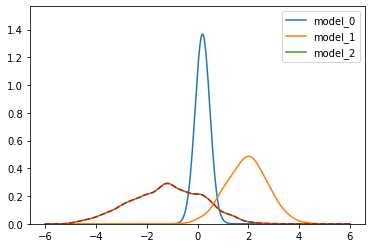

In [13]:
weights = [0.]*len(trace['a_1'])
maxs = [0.]*len(number_coeffs)
X_plot_1 = np.linspace(-6.,6.,10000)
X_plot = X_plot_1
X_plot = [[X_plot_1[i]] for i in range(len(X_plot))]

for j in range(len(number_coeffs)):
  X = []
  for i in range(len(trace['a_1'])):
    X.append([dict1['model_'+str(j)][i]])
  kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
  samples_kde = np.exp(kde.score_samples(X_plot))
  maxs[j] = np.max(samples_kde)
  plt.plot(X_plot,samples_kde,label='model_'+str(j))

  for k in range(len(weights)):
    weights[k] += np.divide(samples_kde[k]*evidence[j],sum_evidence)

plt.plot(X_plot_1,weights,linestyle='--',color='red')
plt.ylim(0.,np.max(maxs)+0.2)
plt.legend()
plt.show()

Finally, to add more insight to the problem, we can compute the posterior predictives under each model and relate that to the Bayes Factors and evidence obtained for each model.

Text(0, 0.5, 'Y')

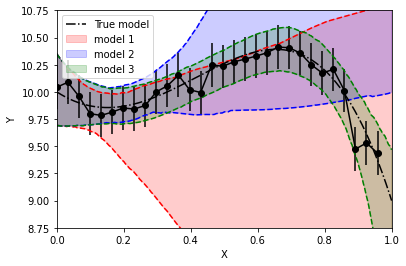

In [20]:
colors=['red','blue','green']
labels = ['model 1', 'model 2', 'model 3']

## Posterior statistics ##
for i in range(len(number_coeffs)):
   names_coeffs = ['a_'+str(i) for i in range(number_coeffs[i])]
   y_ci_plus = []
   y_ci_minus = []
   for l in range(len(x)):
       y_posterior = []
       for p in range(1000):
           coeffs = [trace[names_coeffs[m]][p] for m in range(number_coeffs[i])]
           y_posterior.append(polynomial(coeffs,x[l]))
       y_ci_plus.append(np.percentile(y_posterior,2.5))
       y_ci_minus.append(np.percentile(y_posterior,97.5))

   plt.plot(x,y_ci_plus,linestyle='--',color=colors[i])
   plt.plot(x,y_ci_minus,linestyle='--',color=colors[i])
   plt.fill_between(x,y_ci_plus,y_ci_minus,color=colors[i],alpha=0.2,label=labels[i])

plt.errorbar(x_obs,observations,2*sigma_obs,marker='o',color='black')
plt.plot(x,polynomial(a_true, x),color='black',linestyle = 'dashdot', label='True model')
plt.legend(loc='upper left')
plt.ylim(8.75,10.75)
plt.xlim(0.,1.)
plt.xlabel('X')
plt.ylabel('Y')